<a href="https://colab.research.google.com/github/dannynacker/strobedepression/blob/main/pci_vhq_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


First few participant-level supra scores:
  participant_id              condition          dimension  mean_score
0          12345  Control Music Session        altered_exp    3.076923
1          12345  Control Music Session  altered_awareness    4.000000
2          12345  Control Music Session            arousal    2.500000
3          12345  Control Music Session          attention    4.200000
4          12345  Control Music Session            imagery    2.000000

Group-level supra means:
               condition          dimension  mean_score
0  Control Music Session  altered_awareness    1.833333
1  Control Music Session        altered_exp    2.307692
2  Control Music Session            arousal    1.333333
3  Control Music Session          attention    4.333333
4  Control Music Session            imagery    2.583333

Individual 6D-VHQ Scores:
  participant_id              condition          dimension  mean_score
0          12345  Control Music Session  Geometric_Content         NaN


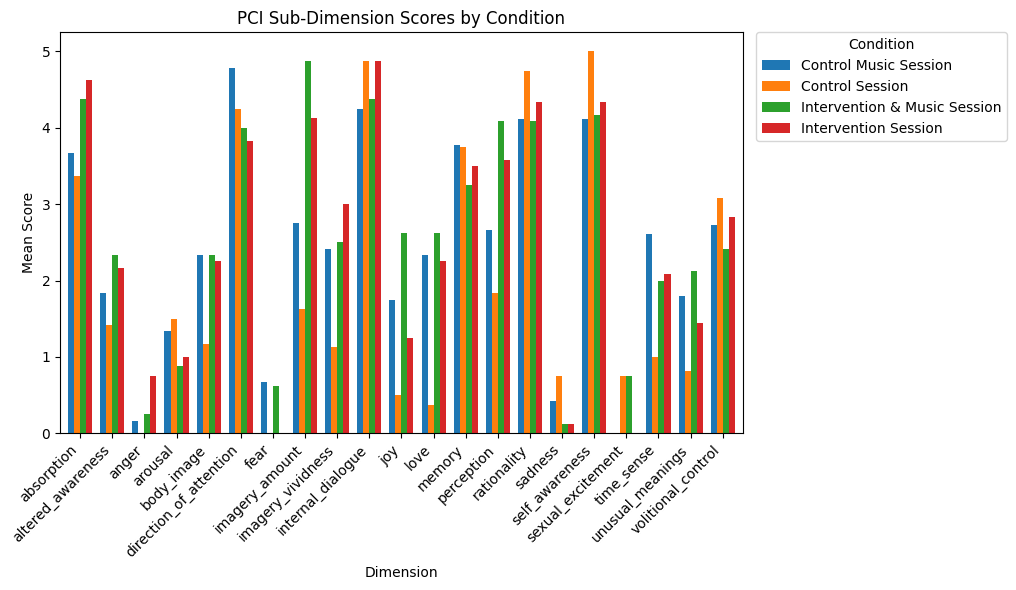

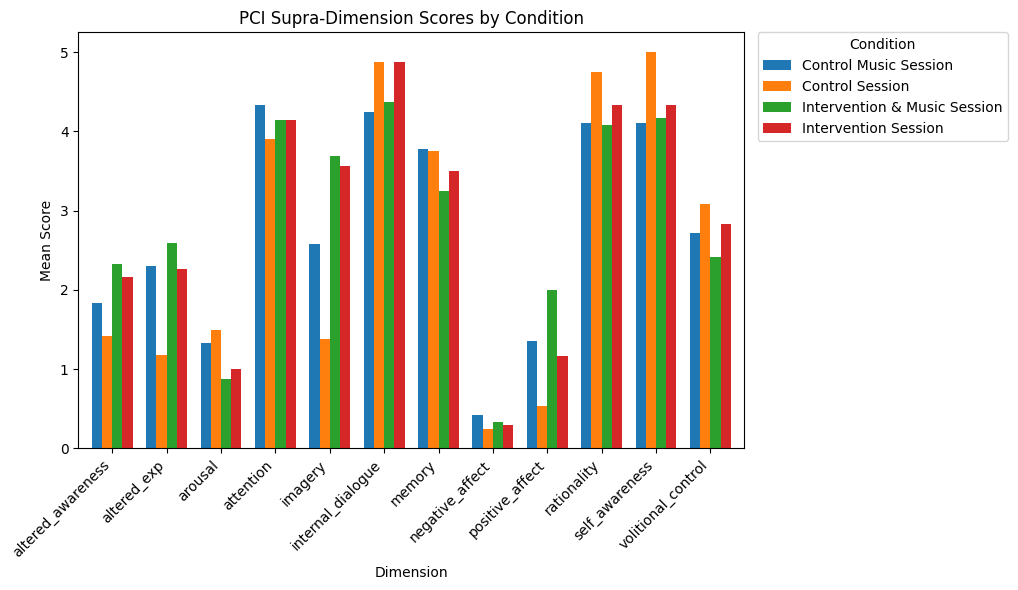

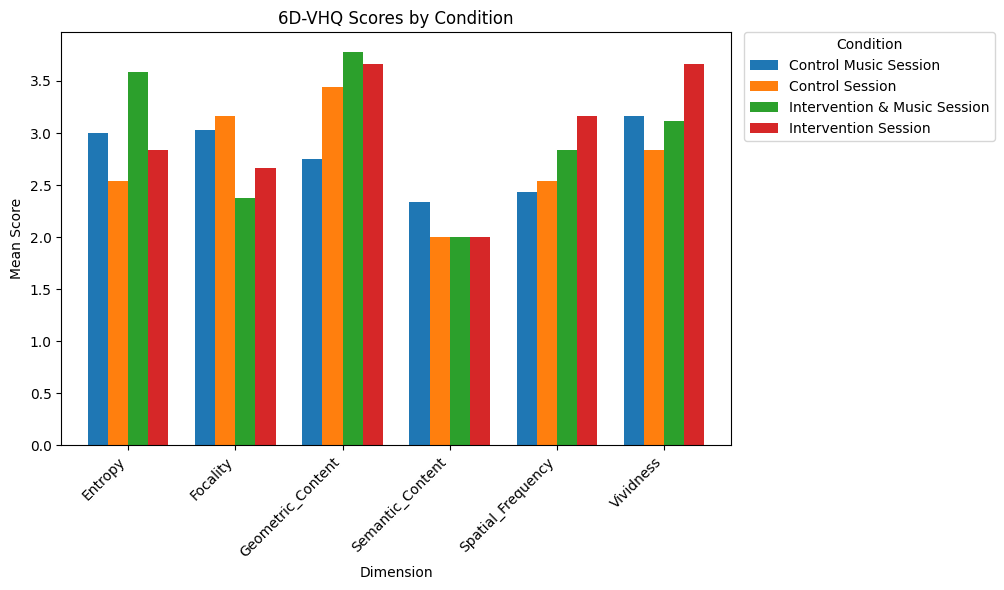

In [17]:
import pandas as pd

# === 1. Load and clean CSV ===
csv_path = "/content/pilot_unclean_4.csv"
df = pd.read_csv(csv_path, skiprows=2)

# Rename true participant/session columns from ImportId
df.rename(columns={
    '{"ImportId":"QID2_TEXT"}': 'participant_id',
    '{"ImportId":"QID18"}': 'condition'
}, inplace=True)

# Confirm columns exist
if "participant_id" not in df.columns or "condition" not in df.columns:
    raise ValueError("Missing 'participant_id' or 'condition' columns after renaming.")

# Normalize condition names
df["condition"] = df["condition"].str.replace(r"\d+\.\s*", "", regex=True).str.strip()

# Remove bad participant IDs
df = df[df["participant_id"].astype(str).str.isnumeric()]
df["participant_id"] = df["participant_id"].astype(str)

# === 2. Rename QCI columns ===
qci_import_ids = [f'{{"ImportId":"QID16_{167 + i}"}}' for i in range(53)]
qci_renames = {import_id: f"qci_{i+1}" for i, import_id in enumerate(qci_import_ids)}
df.rename(columns=qci_renames, inplace=True)

# === 3. Coerce QCI responses to numeric and drop blanks ===
qci_cols = [f"qci_{i}" for i in range(1, 54)]
df[qci_cols] = df[qci_cols].apply(pd.to_numeric, errors="coerce")
df = df.dropna(subset=qci_cols, how="all")

# === 4. Reverse-code items ===
reverse_coded = [f"qci_{i}" for i in [26, 17, 29, 15, 30, 4, 23, 34, 8, 52, 12, 18, 33, 16, 7, 9,
                                      49, 5, 40, 19, 6, 38, 2, 24, 27, 50, 3, 25]]

def reverse_code(df, reverse_list):
    for col in reverse_list:
        if col in df.columns:
            df[col] = 6 - df[col]
    return df

df = reverse_code(df, reverse_coded)

# === 5. Define dimensions ===
supra_dim = {
    "altered_exp": ["qci_39", "qci_43", "qci_32", "qci_47", "qci_11", "qci_51", "qci_26", "qci_17", "qci_29", "qci_15", "qci_30", "qci_4", "qci_23"],
    "altered_awareness": ["qci_21", "qci_53", "qci_40"],
    "arousal": ["qci_37", "qci_19"],
    "attention": ["qci_1", "qci_28", "qci_34", "qci_52", "qci_8"],
    "imagery": ["qci_12", "qci_18", "qci_44", "qci_48"],
    "internal_dialogue": ["qci_45", "qci_6"],
    "memory": ["qci_10", "qci_22", "qci_38"],
    "negative_affect": ["qci_14", "qci_16", "qci_31", "qci_33", "qci_42", "qci_7"],
    "positive_affect": ["qci_20", "qci_35", "qci_46", "qci_49", "qci_5", "qci_9"],
    "rationality": ["qci_2", "qci_24", "qci_36"],
    "self_awareness": ["qci_13", "qci_27", "qci_50"],
    "volitional_control": ["qci_25", "qci_3", "qci_41"]
}

sub_dim = {
    "absorption": ["qci_1", "qci_34"],
    "altered_awareness": ["qci_21", "qci_40", "qci_53"],
    "anger": ["qci_14", "qci_33"],
    "arousal": ["qci_19", "qci_37"],
    "body_image": ["qci_11", "qci_26", "qci_51"],
    "direction_of_attention": ["qci_28", "qci_52", "qci_8"],
    "fear": ["qci_16", "qci_42"],
    "imagery_amount": ["qci_12", "qci_44"],
    "imagery_vividness": ["qci_18", "qci_48"],
    "internal_dialogue": ["qci_45", "qci_6"],
    "joy": ["qci_46", "qci_9"],
    "love": ["qci_20", "qci_49"],
    "memory": ["qci_10", "qci_22", "qci_38"],
    "perception": ["qci_17", "qci_29", "qci_39"],
    "rationality": ["qci_2", "qci_24", "qci_36"],
    "sadness": ["qci_31", "qci_7"],
    "self_awareness": ["qci_13", "qci_27", "qci_50"],
    "sexual_excitement": ["qci_35", "qci_5"],
    "time_sense": ["qci_15", "qci_30", "qci_43"],
    "unusual_meanings": ["qci_23", "qci_32", "qci_4", "qci_47"],
    "volitional_control": ["qci_25", "qci_3", "qci_41"]
}

# === 6. Compute means ===
def compute_means(dimensions, row):
    return {
        dim: row[items].mean() for dim, items in dimensions.items()
        if all(item in row.index for item in items)
    }

results = []
for (pid, condition), group in df.groupby(["participant_id", "condition"]):
    row = group.iloc[0]  # Use first if duplicated
    supra = compute_means(supra_dim, row)
    sub = compute_means(sub_dim, row)
    results.append({
        "participant_id": pid,
        "condition": condition,
        "supra_means": supra,
        "sub_means": sub
    })

# === 7. Flatten results ===
supra_records = []
sub_records = []
for r in results:
    for k, v in r["supra_means"].items():
        supra_records.append({
            "participant_id": r["participant_id"],
            "condition": r["condition"],
            "dimension": k,
            "mean_score": v
        })
    for k, v in r["sub_means"].items():
        sub_records.append({
            "participant_id": r["participant_id"],
            "condition": r["condition"],
            "dimension": k,
            "mean_score": v
        })

df_supra = pd.DataFrame(supra_records)
df_sub = pd.DataFrame(sub_records)

# === 8. Group averages ===
grouped_supra = df_supra.groupby(["condition", "dimension"])["mean_score"].mean().reset_index()
grouped_sub = df_sub.groupby(["condition", "dimension"])["mean_score"].mean().reset_index()

# === 9. Output ===
print("\nFirst few participant-level supra scores:")
print(df_supra.head())

print("\nGroup-level supra means:")
print(grouped_supra.head())

# === 10. Save to CSV (optional) ===
df_supra.to_csv("individual_qci_supra_scores.csv", index=False)
grouped_supra.to_csv("grouped_qci_supra_scores.csv", index=False)

# === 6D-VHQ Addendum ===

# Rename 6D-VHQ columns using ImportId → vhq_1 ... vhq_20
vhq_qid_mapping = {
    '{"ImportId":"QID1217824659"}': 'vhq_1',
    '{"ImportId":"QID1217824660"}': 'vhq_2',
    '{"ImportId":"QID1217824661"}': 'vhq_3',
    '{"ImportId":"QID1217824662"}': 'vhq_4',
    '{"ImportId":"QID1217824663"}': 'vhq_5',
    '{"ImportId":"QID1217824664"}': 'vhq_6',
    '{"ImportId":"QID1217824665"}': 'vhq_7',
    '{"ImportId":"QID1217824666"}': 'vhq_8',
    '{"ImportId":"QID1217824667"}': 'vhq_9',
    '{"ImportId":"QID1217824668"}': 'vhq_10',
    '{"ImportId":"QID1217824669"}': 'vhq_11',
    '{"ImportId":"QID1217824670"}': 'vhq_12',
    '{"ImportId":"QID1217824671"}': 'vhq_13',
    '{"ImportId":"QID1217824672"}': 'vhq_14',
    '{"ImportId":"QID1217824673"}': 'vhq_15',
    '{"ImportId":"QID1217824674"}': 'vhq_16',
    '{"ImportId":"QID1217824675"}': 'vhq_17',
    '{"ImportId":"QID1217824676"}': 'vhq_18',
    '{"ImportId":"QID1217824677"}': 'vhq_19',
    '{"ImportId":"QID1217824678"}': 'vhq_20'
}
df.rename(columns=vhq_qid_mapping, inplace=True)

# Define dimensions
vhq_dimensions = {
    "Geometric_Content": ['vhq_1', 'vhq_2', 'vhq_3'],
    "Semantic_Content": ['vhq_4', 'vhq_5', 'vhq_6'],
    "Spatial_Frequency": ['vhq_7', 'vhq_8', 'vhq_9'],
    "Vividness": ['vhq_10', 'vhq_11', 'vhq_12'],
    "Entropy": ['vhq_13', 'vhq_14', 'vhq_15'],
    "Focality": ['vhq_16', 'vhq_17', 'vhq_18'],
    "Infrequency": ['vhq_19', 'vhq_20']
}

vhq_reverse_items = ['vhq_10', 'vhq_11', 'vhq_12', 'vhq_17']

# Coerce to numeric and reverse-score
vhq_cols = [q for qs in vhq_dimensions.values() for q in qs]
df[vhq_cols] = df[vhq_cols].apply(pd.to_numeric, errors='coerce')
for col in vhq_reverse_items:
    if col in df.columns:
        df[col] = 6 - df[col]  # Assuming 0–6 scale

# Compute participant-level VHQ scores
vhq_results = []
for (pid, condition), group in df.groupby(["participant_id", "condition"]):
    row = group.iloc[0]
    vhq_scores = {
        dim: row[items].mean()
        for dim, items in vhq_dimensions.items()
        if all(item in row.index for item in items)
    }
    for dim, mean_score in vhq_scores.items():
        vhq_results.append({
            "participant_id": pid,
            "condition": condition,
            "dimension": dim,
            "mean_score": mean_score
        })

df_vhq = pd.DataFrame(vhq_results)
grouped_vhq = df_vhq.groupby(["condition", "dimension"])["mean_score"].mean().reset_index()

# Output
print("\nIndividual 6D-VHQ Scores:")
print(df_vhq.head())

print("\nGroup-Level 6D-VHQ Scores:")
print(grouped_vhq.head())

# Optional export
df_vhq.to_csv("individual_6dvhq_scores.csv", index=False)
grouped_vhq.to_csv("grouped_6dvhq_scores.csv", index=False)

import matplotlib.pyplot as plt

def plot_grouped_bar(df, title):
    """
    Plots a grouped bar chart for a given dataframe and moves legend outside.
    Assumes df has columns: 'dimension', 'condition', 'mean_score'
    """
    pivot_df = df.pivot(index="dimension", columns="condition", values="mean_score")
    ax = pivot_df.plot(kind="bar", figsize=(12, 6), width=0.75)

    # Titles and axis labels
    plt.title(title)
    plt.ylabel("Mean Score")
    plt.xlabel("Dimension")
    plt.xticks(rotation=45, ha='right')

    # Move legend outside plot area
    plt.legend(title="Condition", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    # Adjust layout to fit legend
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()

# === Plot all three ===
plot_grouped_bar(grouped_sub, "PCI Sub-Dimension Scores by Condition")
plot_grouped_bar(grouped_supra, "PCI Supra-Dimension Scores by Condition")
plot_grouped_bar(grouped_vhq_filtered, "6D-VHQ Scores by Condition")